In [75]:
# 导入环境的包

import sys
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt  # this is used for the plot the graph
import seaborn as sns  # used for plot interactive graph.
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, r2_score
from pylab import rcParams
from pandas.plotting import register_matplotlib_converters

## keras
from tcn import TCN
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.models import Sequential

In [76]:
# config matplotlib
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#93D30C", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 30, 10
register_matplotlib_converters()

In [77]:
#将序列转为监督学习序列数据
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    dff = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(dff.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(dff.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [78]:
daily_cases_China = pd.read_csv('new_daily_cases/new_daily_cases_China.csv').iloc[:,1:]
df_resample=daily_cases_China.T
df_resample

,0
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,0.0
1/27/20,0.0
...,...
5/10/22,7895.0
5/11/22,7357.0
5/12/22,7118.0
5/13/22,6768.0


In [79]:
## * Note: 归一化数据范围为0-1.

values = df_resample.values 
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# 数据转为监督学习数据，time-step=1
reframed = series_to_supervised(scaled, 1, 1)

In [80]:
# 划分数据集
values = reframed.values
#https://easy-station.taobao.com/
#一般训练数据集以总数据的*0.7，测试数据以总数据的*0.3，
n_train_time = 812 #以813天数据训练
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# 构建数据的3D 格式，即[samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
test_y

(812, 1, 1) (812,) (30, 1, 1) (30,)


array([1.        , 0.        , 0.53925039, 0.56787152, 0.59394405,
       0.60996379, 0.62539695, 0.32889015, 0.5947329 , 0.58563078,
       0.57193713, 0.56089322, 0.51505896, 0.49701653, 0.46906289,
       0.51687939, 0.47126762, 0.39658974, 0.32565384, 0.2904185 ,
       0.25415158, 0.22909039, 0.1980218 , 0.18285159, 0.17188859,
       0.15969174, 0.14880964, 0.1439754 , 0.13689597, 0.1255082 ])

# 构建TCN-Attention模型

### 1) TCN 卷积个数32，卷积核3等
### 2) dropout 层20%
### 3) 1个神经元在输出层中，用于预测Global_Active_Power。
### 4) 输入形状为1个时间步长，有7个特征

### 5)使用了平均绝对误差（MAE）损失函数和随机梯度下降的有效Adam。
### 6)  epochs=100, batch size = 10.

Epoch 1/10
82/82 - 4s - loss: 0.0030 - val_loss: 0.5889
Epoch 2/10
82/82 - 0s - loss: 0.0686 - val_loss: 3.0447
Epoch 3/10
82/82 - 0s - loss: 0.0045 - val_loss: 0.1942
Epoch 4/10
82/82 - 0s - loss: 0.0041 - val_loss: 0.1679
Epoch 5/10
82/82 - 0s - loss: 0.0038 - val_loss: 0.1097
Epoch 6/10
82/82 - 0s - loss: 0.0029 - val_loss: 0.2064
Epoch 7/10
82/82 - 0s - loss: 0.0020 - val_loss: 0.0749
Epoch 8/10
82/82 - 0s - loss: 6.1980e-04 - val_loss: 0.1583
Epoch 9/10
82/82 - 0s - loss: 7.7970e-04 - val_loss: 0.0784
Epoch 10/10
82/82 - 0s - loss: 0.0025 - val_loss: 0.0669


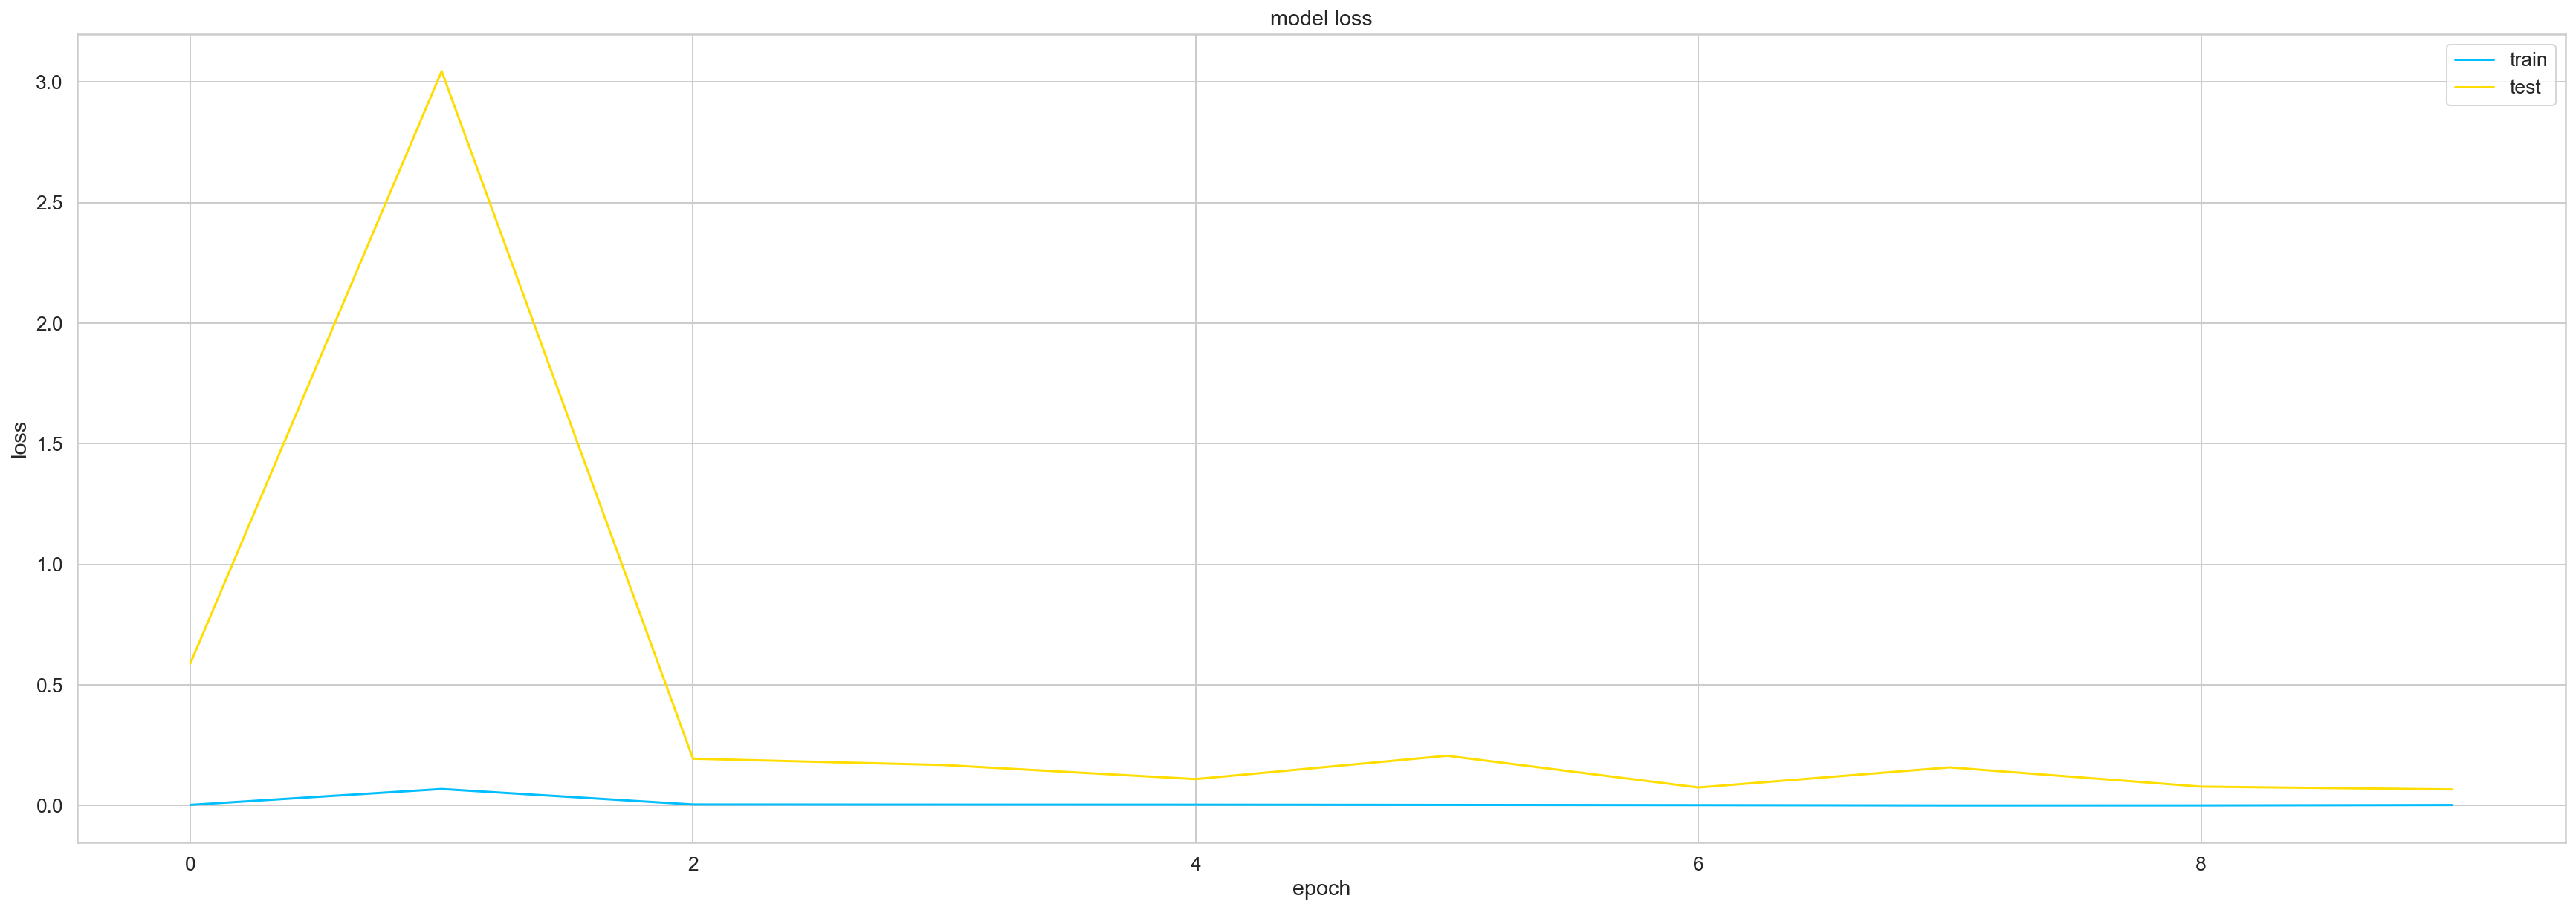

Test RMSE: 12785.842


In [81]:
#网络模型
model = Sequential()
model.add(TCN(nb_filters=32,kernel_size=3,padding='causal', dilations=(1, 2, 4, 8,16), input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')

# fit network
history = model.fit(train_X, train_y, epochs=10, batch_size=10, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# 显示训练的loss值情况
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# 做预测
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 1))
# i反归一化预测值
inv_yhat = np.concatenate((yhat, test_X[:,:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# 反归一化真实值
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:,:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# 计算 RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

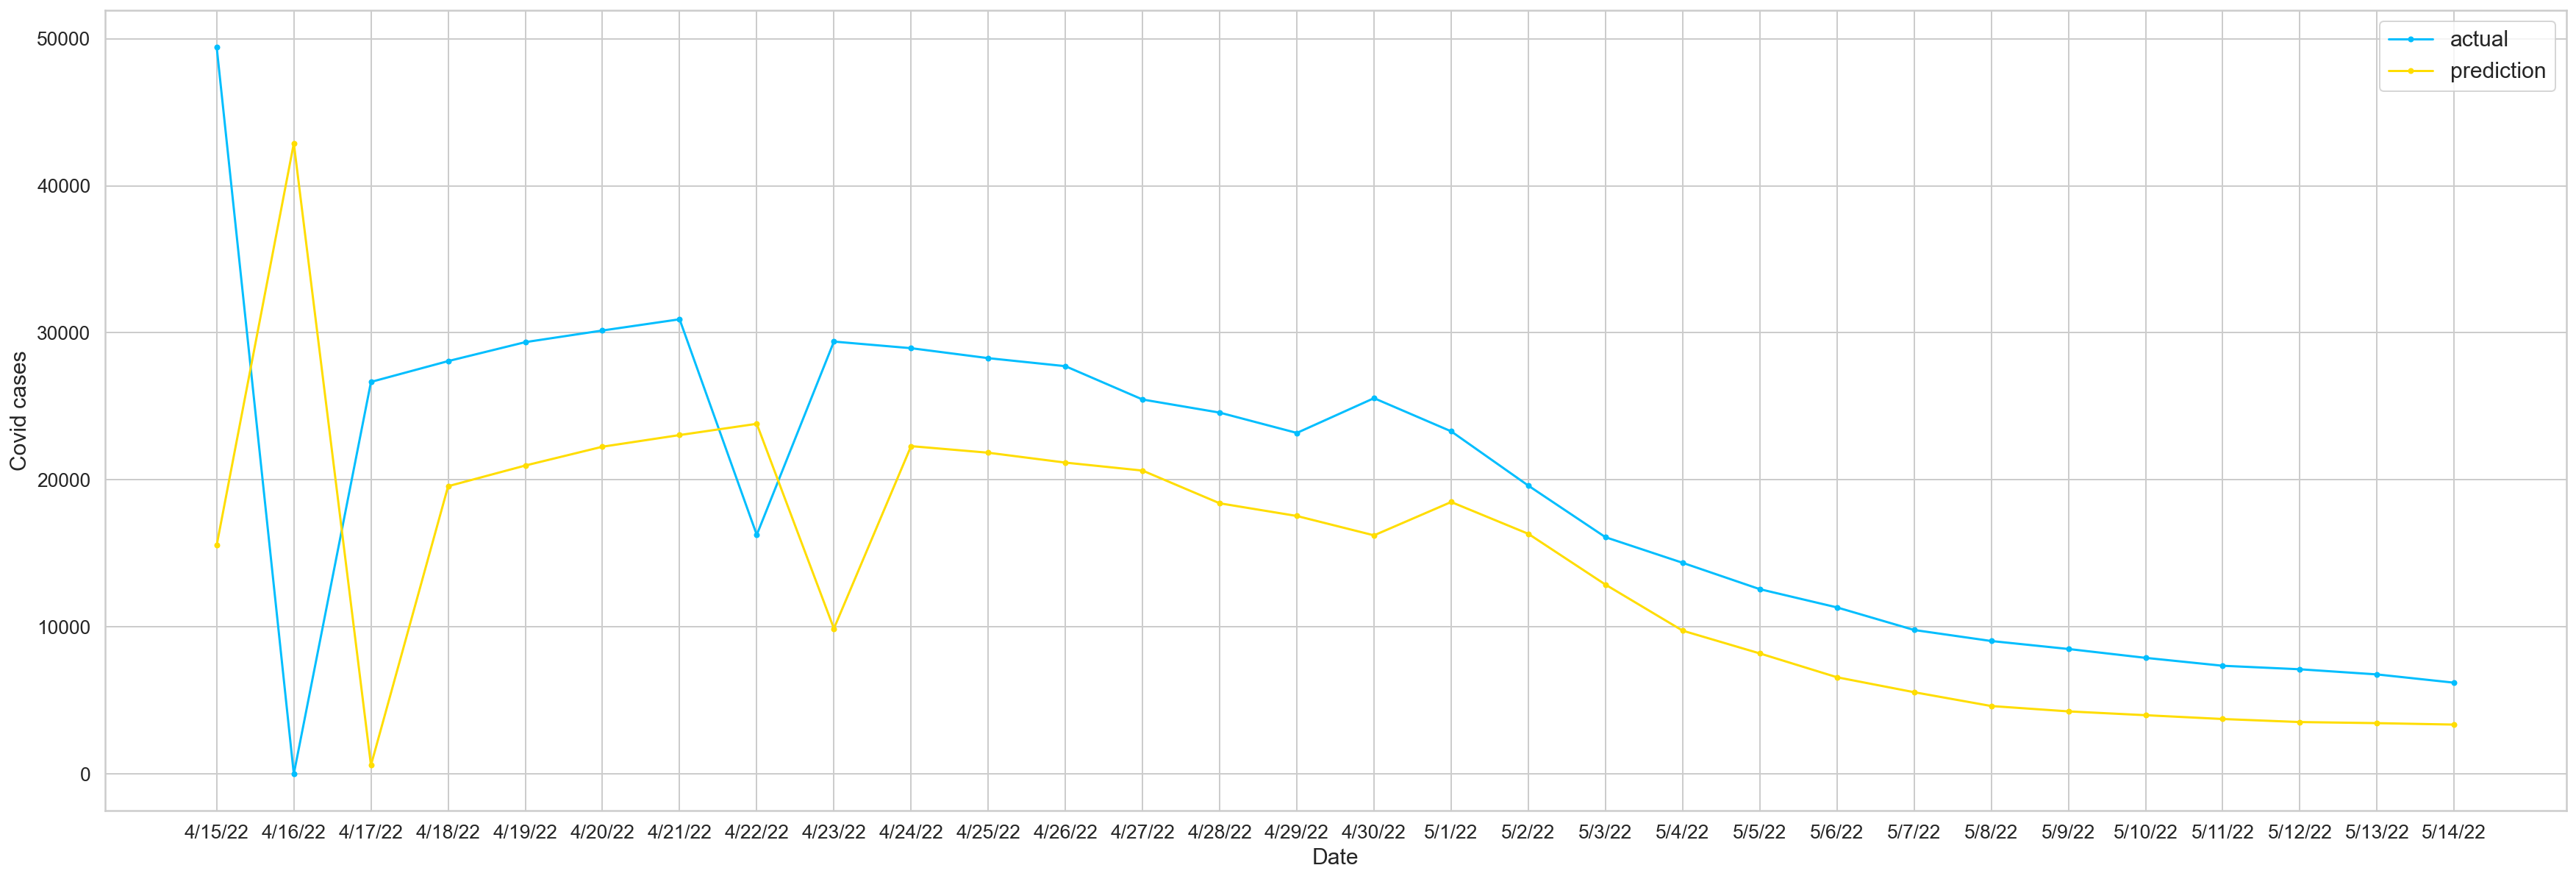

In [82]:
# 时间步长，每个步长为一小时（您可以轻松地将时间步长转换为实际时间索引）
# 为了演示，我只比较了200小时内的预测. 
#显示预测结果
plt.plot(df_resample.index[-30:], inv_y[-30:], marker='.', label="actual")
plt.plot(df_resample.index[-30:], inv_yhat[:],  marker='.',label="prediction")
plt.ylabel('Covid cases', size=15)
plt.xlabel('Date', size=15)
plt.legend(fontsize=15)
plt.show()